# CIS 545 Final Project: Covid Vaccine Tweet Analysis

Celine Cheung, Sarah Hilado, and Jimmy Ren

# Introduction and Background

In this project, we aimed to study and visualize the nature of COVID-19 vaccine related tweets throughout the pandemic–– with a special focus on the sentiment of tweets accross time and location. We began with exploratory data analysis to extract sentiment and location of tweets and visualized our findings. Next, we used various machine learning models to predict popularity (via number of retweets) of vaccine-related tweets. Finally, we attempted a time series analysis to see if we could find patterns in the popularity of tweets over time but found that it was difficult to do given the nature of our dataset.

Overall, we feel that this was an extremely rewarding project that gave us interesting insights into COVID-19 vaccine related tweets.

# Pre-Processing and EDA

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import re
import nltk
from nltk.corpus import stopwords

In [2]:
!pip install afinn
from afinn import Afinn

## Data Cleaning and Initial Observations

---



Let us first load our data and take an initial look. The dataset we are using is a collection of COVID vaccine related tweets collected from December 2020 - present (April 2021) from all over the world. The dataset can be found here: https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
tweets = pd.read_csv('/content/drive/MyDrive/CIS545_GroupProject/vaccination_all_tweets.csv')
tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [5]:
tweets.shape

(69718, 16)

In [6]:
tweets.nunique().to_frame()

,0
id,69718
user_name,37139
user_location,12761
user_description,35883
user_created,37789
user_followers,12271
user_friends,6052
user_favourites,22440
user_verified,2
date,68930


We can see that our dataset has 69718 rows and 16 columns with users tweeting from what initially appears to be 12,271 unique locations around the world (we will process location data later to get a better idea of this). 

Not all of the data in this initial dataframe is useful, so we will drop columns unnecessary to our analysis.

In [7]:
tweet_text = tweets.drop(columns=['user_name', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'source', 'favorites', 'is_retweet'])

Now, let's convert our dates into datetime objects and add columns for the month, week, and day of the tweet since using the exact time each tweet was posted isn't useful for analyzing trends.

In [8]:
tweet_text['date'] = pd.to_datetime(tweet_text['date'])
tweet_text.sort_values(by='date',inplace=True)

In [9]:
tweet_text['day'] = tweet_text['date'].dt.to_period('D').values.astype('datetime64[D]')
tweet_text['day'] = tweet_text['day'].apply(lambda x: x.date())

tweet_text['month_year'] = tweet_text['date'].dt.to_period('M').values.astype('datetime64[M]')

In [10]:
tweet_text['week'] = tweet_text['date'].dt.to_period('W').values.astype('datetime64[W]')
tweet_text['week'] = tweet_text['week'].apply(lambda x: x.date())

In [11]:
#deleting the last week of data since it is incomplete
tweet_text = tweet_text[tweet_text['date'] < dt(2021, 4, 16)]

We can now take a look at the number of tweets posted per week:

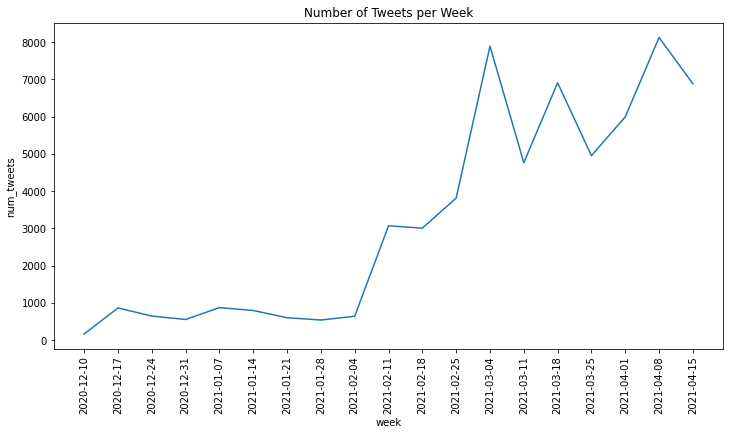

In [12]:
twts_byweek = tweet_text[['week', 'text']].groupby(by='week').count().sort_values(by='week').reset_index()
twts_byweek.rename(columns={'text': 'num_tweets'},inplace=True)

plt.figure(figsize=(12,6))
chart = sns.lineplot(data=twts_byweek, x='week',y='num_tweets')
chart.set_title('Number of Tweets per Week')
chart.set(xticks=twts_byweek.week.values)
chart.set_xticklabels(labels=twts_byweek['week'],rotation=90)
plt.show()

We can observe a few clear upticks in the number of vaccine related tweets in the weeks of 2/11/2021, 3/4/21, 3/18/2021, and 4/8/2021.

Our next step is to clean the text data. For our purposes, we are mainly concerned with analyzing the content and sentiment of the tweets across different metrics, so we will clean the text of unnecessary symbols in the following ways:
-  remove URLs
-  remove username tags (e.g. @DonaldTrump)
-  remove the hashtag symbol (we will not be removing the text of the hashtag themselves, since they can be useful for sentiment analysis once segmented)
-  remove the retweet symbol (RT)
- remove the new line symbol

In [13]:
def clean_text(text):
  text = re.sub('https?://[A-Za-z0-9./]+','', text) #remove links
  text = re.sub(r'@[A-Z0-9a-z_:]+','', text) #remove user tags
  text = re.sub(r'#', '', text) #remove hashtag symbol
  text = re.sub(r'RT[\s]+', '', text) #remove retweet symbol
  text = re.sub("\n","",text) #remove new line symbol
  text = text.lower() 
  return text
  

In [14]:
tweet_text['text'] = tweet_text['text'].apply(clean_text)

## Sentiment Analysis

There are a number of ways to evaluate sentiment of bodies of text. We have chosen to use the afinn library for our sentiment analysis. Documentation can be found here: https://pypi.org/project/afinn/#description

In [15]:
afinn = Afinn(language='en', emoticons=True)
tweet_text['score'] = tweet_text['text'].apply(afinn.score)

In [16]:
tweet_text['score'].describe().to_frame()

,score
count,61058.000000
mean,0.423843
std,2.194068
min,-14.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,17.000000


We can see that the lowest sentiment tweet has a score of -15, the highest sentiment tweet has a score of 17, and the average sentiment of all of the tweets is slightly positive at a score of ~0.4

Let's take a a look at average tweet sentiment per week.

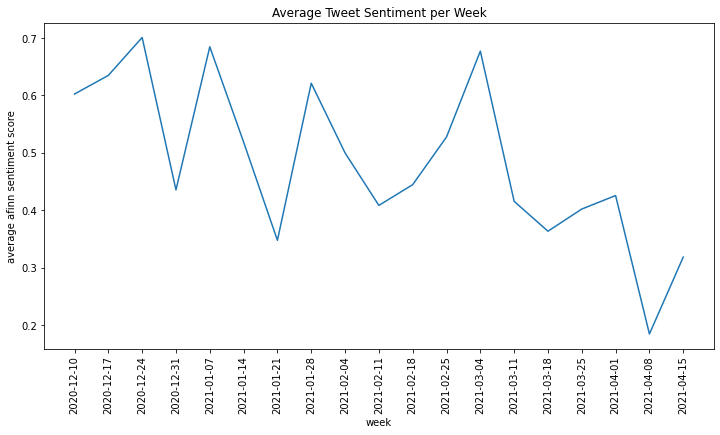

In [17]:
sentiment_byweek = tweet_text[['week', 'score']].groupby(by='week').mean().sort_values(by='week').reset_index()
plt.figure(figsize=(12,6))
chart = sns.lineplot(data=sentiment_byweek, x='week',y='score')
chart.set(xticks=sentiment_byweek.week.values)
chart.set(ylabel='average afinn sentiment score')
chart.set_xticklabels(labels=sentiment_byweek['week'],rotation=90)
chart.set_title('Average Tweet Sentiment per Week')
plt.show()

We can see that tweet sentiment regarding covid vaccines has fluctuated from week to week, but has managed to remain slightly positive on average for every single week since the week of December 10th, 2020.

To take a closer look, let's see the average sentiment of tweets per day.

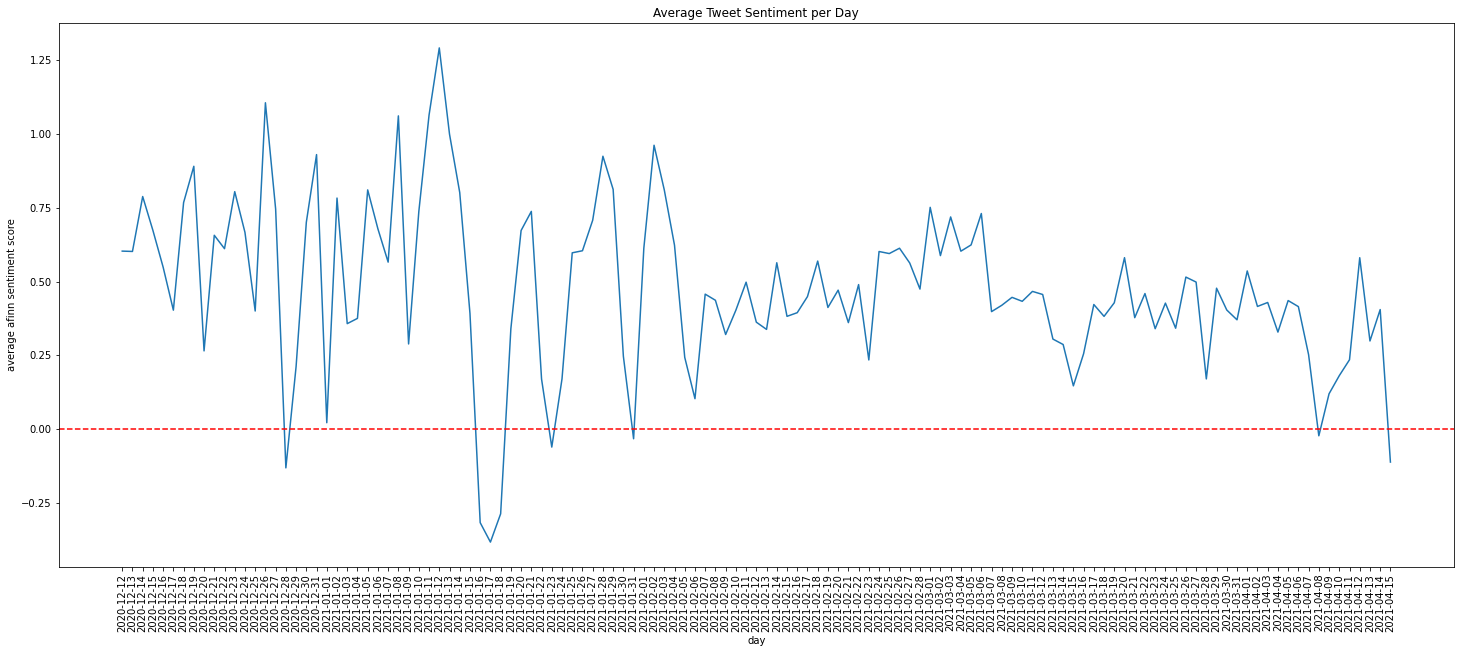

In [18]:
sentiment_byday = tweet_text[['day', 'score']].groupby(by='day').mean().sort_values(by='day').reset_index()

plt.figure(figsize=(25,10))
chart = sns.lineplot(data=sentiment_byday, x='day',y='score')
chart.set(xticks=sentiment_byday.day.values)
chart.set(ylabel='average afinn sentiment score')
chart.set_title('Average Tweet Sentiment per Day')
chart.set_xticklabels(labels=sentiment_byday['day'],rotation=90)
chart.axhline(0, ls='--', color='red')
plt.show()

Again, we can see average tweet sentiment per day has been positive for the majority of the time, with a few outliers where sentiment dipped into the negative. One of those outliers includes a three day dip from 1/16/21-1/19/21.

Aside from looking at the specific sentiment scores, we can categorize each tweet into positive, negative, and neutral sentiment respectively.

In [19]:
tweet_text['label'] = tweet_text['score'].apply(lambda x: 'positive' if x > 0 else 'neutral' if x == 0 else 'negative')

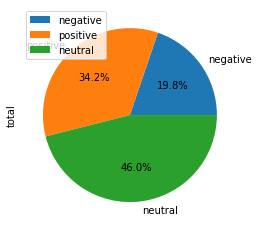

In [20]:
total = tweet_text[['text','label']].groupby(by=['label']).count().sort_values(by='text')
total.rename(columns={'text':'total'},inplace=True)
total
total.plot.pie(autopct="%.1f%%", y='total',x='label')

There appears to be 12,084 tweets with negative sentiment, 20, 860 tweets with positive sentiment, and 28,114 tweets with neutral sentiment. We can track these over time as well.

In [21]:
by_week = tweet_text[['text','label','week']].groupby(by=['week','label']).count().sort_values(by='week').reset_index()
by_week.rename(columns={'text':'total'},inplace=True)

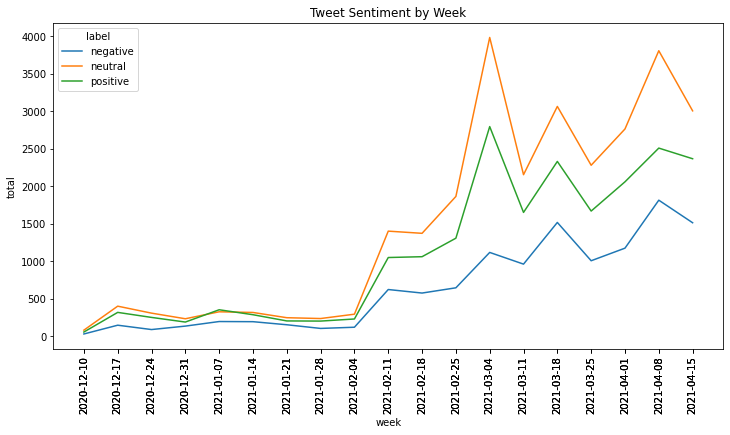

In [22]:
plt.figure(figsize = (12,6))
chart = sns.lineplot(x = by_week['week'], y = by_week['total'], hue = by_week['label'])
chart.set(xticks=by_week.week.values)
chart.set_title('Tweet Sentiment by Week')
chart.set_xticklabels(labels=by_week['week'],rotation=90)
plt.show()

It would appear as though almost every week, there were consistently the most neutral tweets, followed by positive tweets, and the least amount of negative tweets.

In order to analyze the individual words in each tweet, let's tokenize the text using the nltk toolkit.

In [23]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english')) 
def tokenize_content(content):
  """returns tokenized string

  :param content: text string
  :return: tokenized text/list of words
  """
  words = nltk.word_tokenize(content)
  tok = [word.lower() for word in words if word.isalpha() and word.lower() not in stopwords]
  return tok

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We can tokenize tweets by sentiment and then create word clouds to visualize:
- most common words in all the tweets
- most common in negative tweets
- most common in neutral
- most common in positive

In [24]:
for_wordcloud = tweet_text[['text','label']]

In [25]:
nltk.download('punkt')

tweets_tokens = []
for x in for_wordcloud['text']:
  tweets_tokens.append(tokenize_content(str(x)))
tweets_tokens = [x for sublist in tweets_tokens for x in sublist]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
negative_tweets_tokens = []
for x in for_wordcloud[for_wordcloud['label'] == 'negative']['text']:
  negative_tweets_tokens.append(tokenize_content(str(x)))
negative_tweets_tokens = [x for sublist in negative_tweets_tokens for x in sublist]

neutral_tweets_tokens = []
for x in for_wordcloud[for_wordcloud['label'] == 'neutral']['text']:
  neutral_tweets_tokens.append(tokenize_content(str(x)))
neutral_tweets_tokens = [x for sublist in neutral_tweets_tokens for x in sublist]

positive_tweets_tokens = []
for x in for_wordcloud[for_wordcloud['label'] == 'positive']['text']:
  positive_tweets_tokens.append(tokenize_content(str(x)))
positive_tweets_tokens = [x for sublist in positive_tweets_tokens for x in sublist]

Now, we find the most common words in all the tweets, negative tweets, and neutral tweets, and positive tweets. Note that we will subtract the most common words among the four categories in order to better see the most common words that are unique to each category.

In [27]:
from collections import Counter

all_tweets_counter = Counter(tweets_tokens)
negative_tweets_counter = Counter(negative_tweets_tokens)
neutral_tweets_counter = Counter(neutral_tweets_tokens)
positive_tweets_counter = Counter(positive_tweets_tokens)

#We subtract all counters from each other to avoid any common words between the different sentiments of tweets

all_tweets_counter.subtract(negative_tweets_counter)
all_tweets_counter.subtract(neutral_tweets_counter)
all_tweets_counter.subtract(positive_tweets_counter)
distinct_most_common_tweets = all_tweets_counter.most_common(50)

negative_tweets_counter.subtract(all_tweets_counter)
negative_tweets_counter.subtract(neutral_tweets_counter)
negative_tweets_counter.subtract(positive_tweets_counter)
distinct_most_common_negative_tweets = negative_tweets_counter.most_common(50)

neutral_tweets_counter.subtract(all_tweets_counter)
neutral_tweets_counter.subtract(negative_tweets_counter)
neutral_tweets_counter.subtract(positive_tweets_counter)
distinct_most_common_neutral_tweets = neutral_tweets_counter.most_common(50)

positive_tweets_counter.subtract(all_tweets_counter)
positive_tweets_counter.subtract(negative_tweets_counter)
positive_tweets_counter.subtract(neutral_tweets_counter)
distinct_most_common_positive_tweets = positive_tweets_counter.most_common(50)

Now we can make our word clouds, starting with a wordcloud for the most common words in all of the tweets.

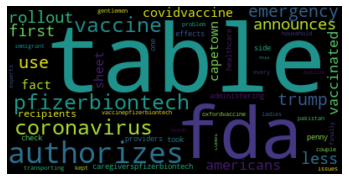

In [28]:
from wordcloud import WordCloud

common_words = ""
for x in distinct_most_common_tweets:
  common_words += " " + x[0]

wordcloud = WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We can then find the word cloud of most common words in negative tweets.

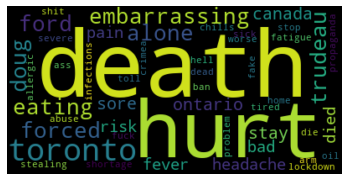

In [29]:
common_negative_words = ""
for x in distinct_most_common_negative_tweets:
  common_negative_words += " " + x[0]

wordcloud = WordCloud().generate(common_negative_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We then find the word cloud of most common words in neutral tweets.

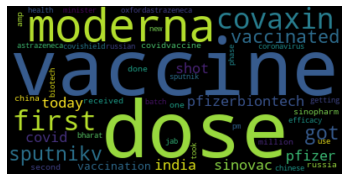

In [30]:
common_neutral_words = ""
for x in distinct_most_common_neutral_tweets:
  common_neutral_words += " " + x[0]

wordcloud = WordCloud().generate(common_neutral_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We then find the word cloud of most common words in positive tweets.

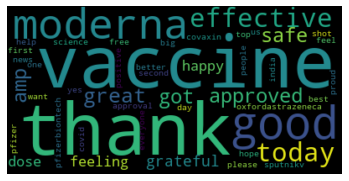

In [31]:
common_positive_words = ""
for x in distinct_most_common_positive_tweets:
  common_positive_words += " " + x[0]

wordcloud = WordCloud().generate(common_positive_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We can thus see that for all tweets, 'fda', 'coronavirus', authorizes' are among the most common words. For negative tweets, 'death' seems to be the most common word, which can imply that users with negative tweets are concerned with the possible harmful side effects of the vaccine. The most common words in neutral and positive tweets are similar, with 'vaccine' and 'moderna' being among the most commmon words.

## Geocoding Analysis

Now, we're going to visualize popular tweets from around the world. We want to be able to see where the most popular COVID-related tweets are across the world using the user location given in the dataset. However, something to note with this is that the user location is set by the user, so it can be a phrase like "my bed" that isn't a valid location on the world map. While we tried to think of a way to remove these, it seemed almost impossible to do so. Instead, we decided to just geocode the data using the MapQuest provider and used the geocoded address to find a real location that we could use.

Because there are over 60,000 entries in this data set, encoding this large amount is almost impossible to do in a reasonable amount of time. Therefore, we used the package Geocoder to determine the first 1,000 most popular covid tweets based on the number of retweets. By doing so, we would be able to plot a reasonable number of tweets and find where the most popular tweets were coming from across the world.

Here, we start by installing the geocdoer.

In [32]:
!pip install geocoder

     |████████████████████████████████| 102kB 2.0MB/s 


Create the geolocator that will geocode the "user_location" that is determined by the user. We want to first see how geocoding a phrase would work out. We use the phrase "My Bed" and use our given key to get a *geojson* to see what it would look like. Next, we wanted to drop the number of NA tweets.

In [33]:
import geocoder

g = geocoder.mapquest('My Bed', key="HQulCncnaNvBRfuETufZDk7USPzENqx6")
print(g.geojson)

## Drop NA values
tweets = tweets[tweets["user_location"].isna() == False]

## New size
print(tweets["user_location"].size)


{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'address': 'MY', 'country': 'MY', 'lat': 3.15443, 'lng': 101.7151, 'ok': True, 'quality': 'COUNTRY', 'raw': {'street': '', 'adminArea6': '', 'adminArea6Type': 'Neighborhood', 'adminArea5': '', 'adminArea5Type': 'City', 'adminArea4': '', 'adminArea4Type': 'County', 'adminArea3': '', 'adminArea3Type': 'State', 'adminArea1': 'MY', 'adminArea1Type': 'Country', 'postalCode': '', 'geocodeQualityCode': 'A1XAX', 'geocodeQuality': 'COUNTRY', 'dragPoint': False, 'sideOfStreet': 'N', 'linkId': 'MY/GEO/p0/0', 'unknownInput': '', 'type': 's', 'latLng': {'lat': 3.15443, 'lng': 101.7151}, 'displayLatLng': {'lat': 3.15443, 'lng': 101.7151}, 'mapUrl': 'http://www.mapquestapi.com/staticmap/v5/map?key=HQulCncnaNvBRfuETufZDk7USPzENqx6&type=map&size=225,160&locations=3.15443,101.7151|marker-sm-50318A-1&scalebar=true&zoom=2&rand=-1065152278'}, 'status': 'OK'}, 'geometry': {'type': 'Point', 'coordinates': [101.7151, 3.15443]}}]}
53

Since geocoding 50,000 points may beyond our capabilites, we will use the first 1,000 most popular tweets, measured by retweets. We then want to get both the latitude and longitude of each of the locations.

In [34]:
pop_tweets = tweets.nlargest(1000, columns='retweets')

pop_lat = pop_tweets['user_location'].apply(lambda x : geocoder.mapquest(x, key="HQulCncnaNvBRfuETufZDk7USPzENqx6").lat)
pop_lng = pop_tweets['user_location'].apply(lambda x : geocoder.mapquest(x, key="HQulCncnaNvBRfuETufZDk7USPzENqx6").lng)

Install the packages for geopandas. This package is really great for graphing datapoints on maps and doing general map visualizations. We wanted to show both a Choropleth map and a map with data points of the tweet locations across the entire world.

In [35]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 3.7MB/s 
     |████████████████████████████████| 6.5MB 539kB/s 
     |████████████████████████████████| 15.3MB 258kB/s 


Import the packages and created the points from the most popular tweets. Graphed it on a world map as seen below.

In [36]:
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon

We're going to need to create GeoDataFrame in order to graph all the data points based on their latitude and longitude. This means we need a special column with geometry, which in this case will be points containing the lat and long. Therefore, we import Point from geometry.

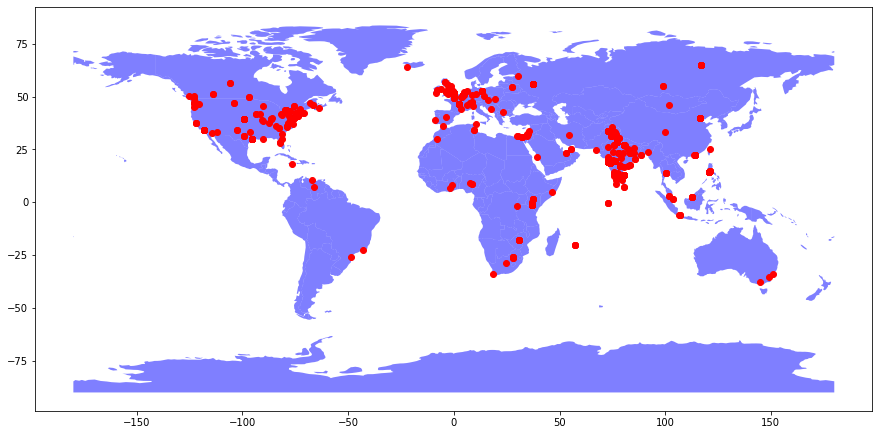

In [37]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, alpha=0.5,color='blue')

geometry = [Point(xy) for xy in zip(pop_lng, pop_lat)]
geo_df = gpd.GeoDataFrame(geometry = geometry)

geo_df.plot(ax = ax, color='red')
plt.show()

We see how the data points are centralized in the United States, India, and Europe. This is pretty interesting to see, and we might want to compare between the countries themselves. 

Here, we will create a heat map of the data in each country. First, we will assemble the data below and then proceed to make the heat map. This will involve getting the country codes provided in the geocoder and then using the same iso code to be able to map between the datapoints and their countries on the map.

In [38]:
pop_country = pop_tweets['user_location'].apply(lambda x : geocoder.mapquest(x, key="HQulCncnaNvBRfuETufZDk7USPzENqx6").country)

In [39]:
!pip install country-converter

     |████████████████████████████████| 51kB 1.9MB/s 
  Created wheel for country-converter: filename=country_converter-0.7.3-cp37-none-any.whl size=52284 sha256=876e56eb297297b70b92b4f763c5a6933f7361610dbfd69ebe687d2d437841e3
  Stored in directory: /root/.cache/pip/wheels/26/01/da/3906a4b98db3939e8fafc46724677b37175e5e07236952b36a
Successfully built country-converter


 not found in regex


       pop_est      continent  ... country num_tweets
0       920938        Oceania  ...     NaN        NaN
1     53950935         Africa  ...     NaN        NaN
2       603253         Africa  ...     NaN        NaN
3     35623680  North America  ...      CA       23.0
4    326625791  North America  ...      US      143.0
..         ...            ...  ...     ...        ...
172    7111024         Europe  ...     NaN        NaN
173     642550         Europe  ...     NaN        NaN
174    1895250         Europe  ...     NaN        NaN
175    1218208  North America  ...     NaN        NaN
176   13026129         Africa  ...     NaN        NaN

[177 rows x 8 columns]


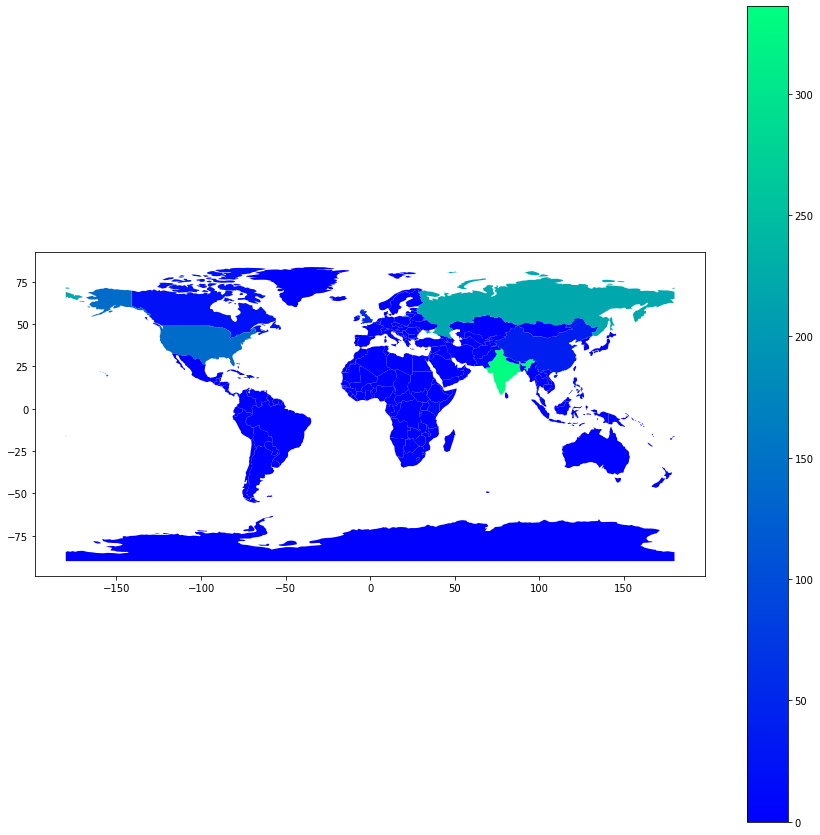

In [40]:
import country_converter as coco
pop_tweets['country'] = pop_country
tweet_per_country = pop_tweets.groupby('country', as_index=False).count()[['country', 'id']]
tweet_per_country = tweet_per_country.rename(columns={'id': 'num_tweets'})

tweet_per_country['iso_a3'] = coco.convert(names=tweet_per_country['country'], to='ISO3')
world_2 = pd.merge(world, tweet_per_country, on=['iso_a3'], how='left')

print(world_2)
world_2['num_tweets'] = world_2['num_tweets'].fillna(0)

fig, ax = plt.subplots(figsize=(15,15))

world_2.plot(ax=ax, column='num_tweets', legend=True, cmap='winter')

This is great! We can see which countries have users producing popular COVID-related tweets across the world. We can see that it appears India is producing the most number of tweets compared to the United States and Russia. This gives us a bit more insight compared to the visualization with the data points, as we can see the frequency in each country. This also gave us an amazing opporunity to work with choropleth maps using Geopandas which we can frequently use in any location-containing data set.

Aside from looking at popular tweets around the world, we can look at other basic graphs for volume of tweets by location and sentiment of tweets by location.

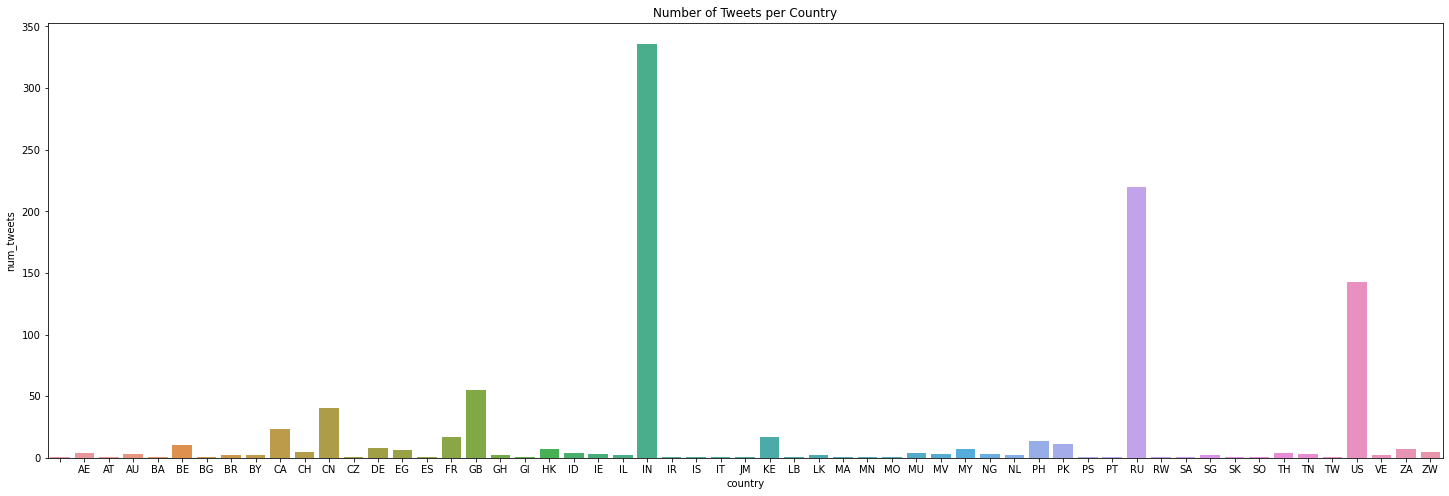

In [73]:
twts_bycountry = tweet_per_country[['country', 'num_tweets']]

plt.figure(figsize=(25, 8))
chart = sns.barplot(data=twts_bycountry, x='country',y='num_tweets')
chart.set_title('Number of Tweets per Country')
plt.show()

It seems that India and Russia have the highest number of tweets by far, with the number of tweets from other countries dropping far below. We then look at the number of tweets per continent.

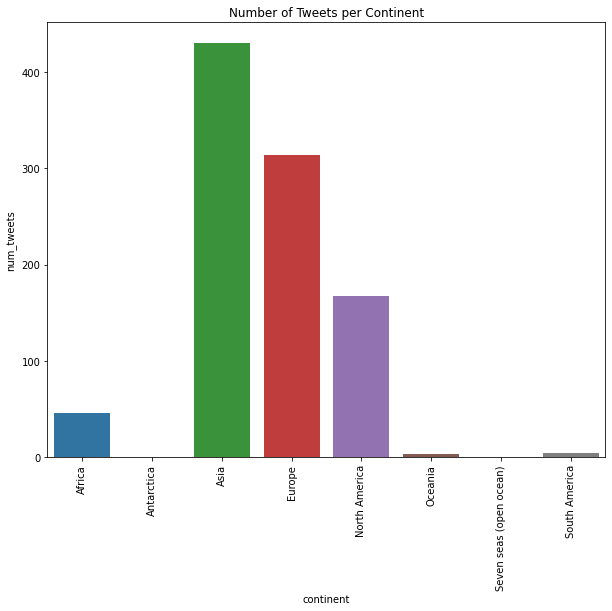

In [74]:
twts_bycontinent = world_2[['continent', 'num_tweets']].groupby(by='continent').sum().sort_values(by='continent').reset_index()

plt.figure(figsize=(10,8))
chart = sns.barplot(data=twts_bycontinent, x='continent',y='num_tweets')
chart.set_title('Number of Tweets per Continent')
chart.set_xticklabels(labels=twts_bycontinent['continent'],rotation=90)
plt.show()

We then look at average tweet sentiment per country.

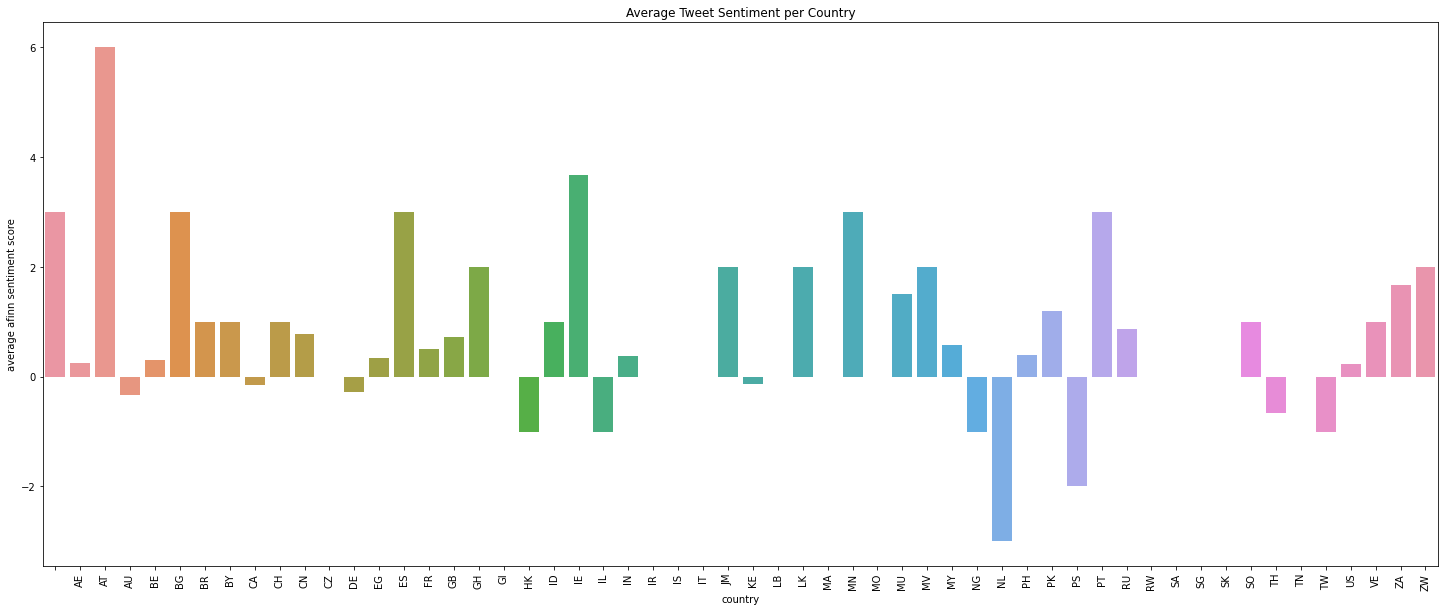

In [43]:
merged_tweets = pd.merge(tweet_text, pop_tweets, how='inner', on='id')
sentiment_bycountry = merged_tweets[['score', 'country']].groupby(by='country').mean().sort_values(by='country').reset_index()

plt.figure(figsize=(25,10))
chart = sns.barplot(data=sentiment_bycountry, x='country',y='score')
chart.set(ylabel='average afinn sentiment score')
chart.set_title('Average Tweet Sentiment per Country')
chart.set_xticklabels(labels=sentiment_bycountry['country'],rotation=90)
plt.show()

Tweets coming from Austria have a very positive sentiment, along with Bulgaria and Ireland, though we should take into account the number of tweets from those countries. Tweets coming from the Netherlands have a very negative sentiment on vaccines. It seems that Europe overall has a very big contrast in sentiment. We then look at average tweet sentiment per continent.

 not found in regex


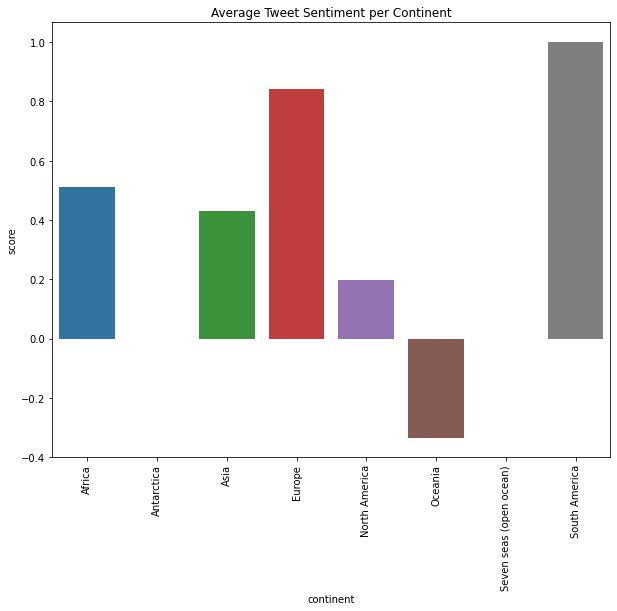

In [44]:
merged_tweets['iso_a3'] = coco.convert(names=merged_tweets['country'], to='ISO3')
world_3 = pd.merge(world, merged_tweets, on=['iso_a3'], how='left')

sentiment_bycont = world_3[['score', 'continent']].groupby(by='continent').mean().sort_values(by='continent').reset_index()

plt.figure(figsize=(10,8))
chart = sns.barplot(data=sentiment_bycont, x='continent',y='score')
chart.set(ylabel='average afinn sentiment score'
chart.set_title('Average Tweet Sentiment per Continent')
chart.set_xticklabels(labels=sentiment_bycont['continent'],rotation=90)
plt.show()

We see that tweets from Sourth America and Europe have positive sentiments, implying that people from those regions are more positive about the vaccines. Tweets from Oceania have a negative sentiment, implying that people from there are more negative.

# Modeling


## Predicting Retweets



Based off the COVID-data, we thought it would be interesting to first create a general model that would be able to predict the number of retweets based off a variety of features. Then, we wanted to compare this over various time periods using time-series analysis with an ARIMA model. In order to start off, we wanted to work with a simple Linear Regression model.

We decided to briefly analyze our data. Our features for this will involve day, month, week, score, user_following, user_followed, user_favorites, and retweets, Let's first create the different columns we will need for our features. We will need to merge with tweet_text to get the data like user_followers, user_friends, user_verified, and favorites. We will use a left join, as we only want to use data with scores from the sentiment analysis we did earlier.

In [45]:
tweets = pd.read_csv('/content/drive/MyDrive/CIS545_GroupProject/vaccination_all_tweets.csv')
tweet_collected = pd.merge(tweet_text, tweets[['id','user_followers', 'user_friends', 'user_verified', 'favorites']], on=['id'], how='left')
tweet_collected.head()

print(tweet_collected)

                        id             user_location  ... user_verified favorites
0      1337727767551553536                     Egypt  ...          True         1
1      1337728701820268544           London, England  ...          True         2
2      1337732077278662657                       NaN  ...         False         1
3      1337732996380696578                     USA🇺🇸  ...         False         0
4      1337733048914358272     Wales, United Kingdom  ...         False         0
...                    ...                       ...  ...           ...       ...
61053  1382844174643437568          Deep Heart Texas  ...         False         2
61054  1382844527119978497           California, USA  ...         False       107
61055  1382844719848296450  RTs are not Endorsements  ...         False         1
61056  1382844894784405506            North America   ...         False         1
61057  1382845560223240196                     Earth  ...          True       614

[61058 rows x 1

Here, we will separate the date into day, week, month, and year.

In [46]:
temp = pd.to_datetime(tweet_collected['date'], format = '%Y-%-m-%d %H:%M:%S')
tweet_collected['day'] = temp.dt.day
tweet_collected['week'] = temp.dt.week
tweet_collected['month'] = temp.dt.month
tweet_collected['year'] = temp.dt.year

tweet_collected.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,id,user_location,date,text,hashtags,retweets,day,month_year,week,score,label,user_followers,user_friends,user_verified,favorites,month,year
0,1337727767551553536,Egypt,2020-12-12 11:55:28,fda authorizes pfizerbiontech coronavirus vacc...,"['FDA', 'PfizerBioNTech', 'coronavirus']",1,12,2020-12-01,50,-2.0,negative,278080,116,True,1,12,2020
1,1337728701820268544,"London, England",2020-12-12 11:59:10,trump announces vaccine rollout 'in less than ...,['vaccine'],0,12,2020-12-01,50,0.0,neutral,66224,603,True,2,12,2020
2,1337732077278662657,NaN,2020-12-12 12:12:35,covidvaccine pfizer-biontech covid-19 pfizerbi...,"['CovidVaccine', 'Pfizer', 'PfizerBioNTech', '...",0,12,2020-12-01,50,0.0,neutral,14,162,False,1,12,2020
3,1337732996380696578,USA🇺🇸,2020-12-12 12:16:14,fact sheet for recipients and caregiverspfizer...,"['PfizerBioNTech', 'CovidVaccine']",0,12,2020-12-01,50,0.0,neutral,2035,1672,False,0,12,2020
4,1337733048914358272,"Wales, United Kingdom",2020-12-12 12:16:27,it's the only one which doesn't have any si...,['PfizerBioNTech'],0,12,2020-12-01,50,0.0,neutral,761,504,False,0,12,2020


Here, we want to do some hot encoding with our categorical data. Since it's just verified vs unverified, there's a lot of ways to do this. However, we just chose to do it like we would if there were more than just 2 categories and relabeled the data.

In [47]:
## Label encoding
tweet_collected = pd.get_dummies(tweet_collected, columns=["user_verified"])
tweet_collected = tweet_collected.rename(columns={'user_verified_True': 'verified', 'user_verified_False' : 'unverified'})
tweet_collected.head()

,id,user_location,date,text,hashtags,retweets,day,month_year,week,score,label,user_followers,user_friends,favorites,month,year,unverified,verified
0,1337727767551553536,Egypt,2020-12-12 11:55:28,fda authorizes pfizerbiontech coronavirus vacc...,"['FDA', 'PfizerBioNTech', 'coronavirus']",1,12,2020-12-01,50,-2.0,negative,278080,116,1,12,2020,0,1
1,1337728701820268544,"London, England",2020-12-12 11:59:10,trump announces vaccine rollout 'in less than ...,['vaccine'],0,12,2020-12-01,50,0.0,neutral,66224,603,2,12,2020,0,1
2,1337732077278662657,NaN,2020-12-12 12:12:35,covidvaccine pfizer-biontech covid-19 pfizerbi...,"['CovidVaccine', 'Pfizer', 'PfizerBioNTech', '...",0,12,2020-12-01,50,0.0,neutral,14,162,1,12,2020,1,0
3,1337732996380696578,USA🇺🇸,2020-12-12 12:16:14,fact sheet for recipients and caregiverspfizer...,"['PfizerBioNTech', 'CovidVaccine']",0,12,2020-12-01,50,0.0,neutral,2035,1672,0,12,2020,1,0
4,1337733048914358272,"Wales, United Kingdom",2020-12-12 12:16:27,it's the only one which doesn't have any si...,['PfizerBioNTech'],0,12,2020-12-01,50,0.0,neutral,761,504,0,12,2020,1,0


We need to remove all the unnecessary columns (non-numeric). This includes id, text, user_location, date, hashtags, retweets, month-year, and label.

In [48]:
label = tweet_collected['retweets']
features = tweet_collected.drop(columns=['id', 'text','user_location', 'label', 'date', 'hashtags', 'retweets','month_year'])

Our data is now ready for analysis and learning! We chose to do the standard 80-20 split and use the *sklearn* package for our Linear Regression model.

In [49]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2)
print(features)

       day  week  score  user_followers  ...  month  year  unverified  verified
0       12    50   -2.0          278080  ...     12  2020           0         1
1       12    50    0.0           66224  ...     12  2020           0         1
2       12    50    0.0              14  ...     12  2020           1         0
3       12    50    0.0            2035  ...     12  2020           1         0
4       12    50    0.0             761  ...     12  2020           1         0
...    ...   ...    ...             ...  ...    ...   ...         ...       ...
61053   15    15    0.0            6388  ...      4  2021           1         0
61054   15    15   -2.0            5635  ...      4  2021           1         0
61055   15    15   -2.0            5199  ...      4  2021           1         0
61056   15    15    2.0           16108  ...      4  2021           1         0
61057   15    15    2.0          349615  ...      4  2021           0         1

[61058 rows x 10 columns]


In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import sklearn

regression_model = LinearRegression().fit(x_train, y_train)
y_pred = regression_model.predict(x_test)

mse_test = mean_squared_error(y_test, y_pred)
print(mse_test)



230.84488619510702


Based on our original model, our MSE is pretty high. Therefore, we will try to look at the data and features to try to improve our model. As suggested in lecture, scaling that data would matter if we were using regularization (otherwise, Linear Regression is scale-invariant). We also want to consider using PCA to remove any noise that might come up. There may also be multi-collinearity that we would need to look at.

In [51]:
## Standardization
from sklearn.preprocessing import StandardScaler

scaled_features = StandardScaler().fit_transform(features)

Here, we will now resplit the data and train.

In [52]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2)


Text(0, 0.5, 'Cumulative Explained Variance')

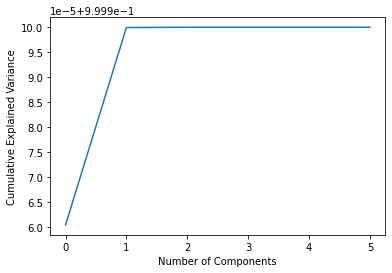

In [53]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
pca.fit(x_train)

cum_explaned_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

Hmm. Here, there appears to be a bit of a problem with our analysis that suggests something may be violated. Let's try to use around 3 or 4 components for our PCA to see how it works out.

In [54]:
## Fit the PCA on the training data and the test data
pca = PCA(n_components=4)
pca.fit(x_train)
x_train = pca.transform(x_train)

pca = PCA(n_components=4)
pca.fit(x_test)
x_test = pca.transform(x_test)

regression_model = LinearRegression().fit(x_train, y_train)
y_pred = regression_model.predict(x_test)

mse_test = mean_squared_error(y_test, y_pred)
mse_test

1172.8011451987973

As we can see, the PCA and standardization had a marginal effect on our regression model. There might be something else wrong that we will have to look at. Let us next create the correlation matrix with a heatmap. In this heatmap, we are looking for high correlation (positive or negative) between **different** features. We will use seaborn to better visualize this data.

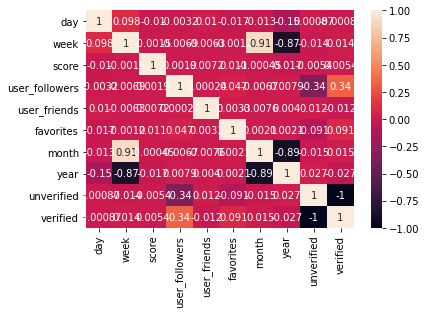

In [55]:
import seaborn as sn
corr_mat = features.corr()
sn.heatmap(corr_mat, annot=True)
plt.show()

Based on the matrix, most of the relevant features (ignoring the date features) are not highly correlated. We may have another issue here based off the correlation matrix! We were expecting possible correlation here but there appears to be nothing.

Another possibility is that our prediction variable may possible be skewed. This would be problematic and may require us to transfrom the data to normalize it, which is an essential assumption that we make of the data. We can check that using a simple histogram of the number of retweets.

                        id             user_location  ... unverified verified
1      1337728701820268544           London, England  ...          0        1
2      1337732077278662657                       NaN  ...          1        0
3      1337732996380696578                     USA🇺🇸  ...          1        0
4      1337733048914358272     Wales, United Kingdom  ...          1        0
5      1337733857349677059     Wales, United Kingdom  ...          1        0
...                    ...                       ...  ...        ...      ...
61051  1382842843522244615       Southern California  ...          1        0
61052  1382843544298266632          Water Valley, MS  ...          1        0
61053  1382844174643437568          Deep Heart Texas  ...          1        0
61055  1382844719848296450  RTs are not Endorsements  ...          1        0
61056  1382844894784405506            North America   ...          1        0

[41140 rows x 18 columns]


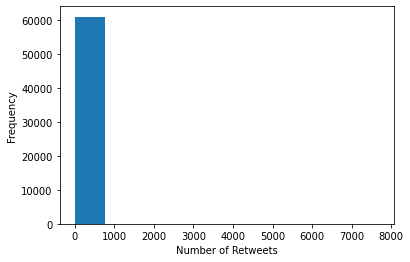

In [56]:
## Get the number of retweets with length greater than 0
plt.hist(tweet_collected['retweets'], bins = 10)
print(tweet_collected[tweet_collected['retweets'] == 0])
plt.xlabel('Number of Retweets')
plt.ylabel('Frequency')
plt.show()

Clearly, this data is very much left skewed - there are almost 60,000 tweets with the number of retweets being 0. Therefore, we will try to rescale the data by first doing a log-transformation. However, we are expecting it to not do much. Inheritenly, the number of retweets for any tweets may typically be 0 unless the user is well-connected. Note that since the number of retweets can be any non-negative number, we do log(x + 1) to account for the fact that np.log(0) would be negative infinity.

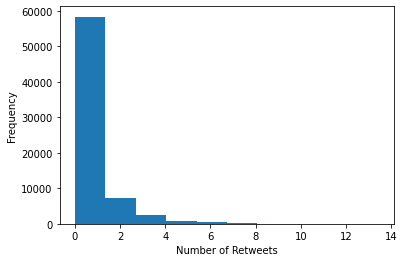

In [57]:
plt.hist(tweets['retweets'].apply(lambda x: np.log2(x + 1)))
plt.xlabel('Number of Retweets')
plt.ylabel('Frequency')
plt.show()

Here, we can see that the data is still skewed, but has improved. Since this violates the normality assumption we come in with, this suggests we use another model. We will first use this log-transformed data to see if there are any improvements and use another model.

In [58]:
tweet_collected['retweets'] = tweet_collected['retweets'].apply(lambda x: np.log(x + 1))

In [59]:
label = tweet_collected['retweets']
features = tweet_collected.drop(columns=['id', 'text','user_location', 'label', 'date', 'hashtags', 'retweets','month_year'])

We will now be able to relearn our model with this transformed feature.

In [60]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2)

0.5520672276110795


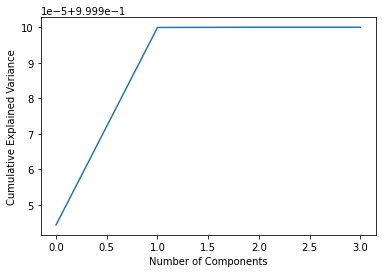

In [61]:
pca = PCA(n_components=4)
pca.fit(x_train)

cum_explaned_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

pca = PCA(n_components=4)
pca.fit(x_train)
x_train = pca.transform(x_train)

pca = PCA(n_components=4)
pca.fit(x_test)
x_test = pca.transform(x_test)

regression_model = LinearRegression().fit(x_train, y_train)
y_pred = regression_model.predict(x_test)

mse_test = mean_squared_error(y_test, y_pred)
print(mse_test)



Clearly, linearity While we have lowered our MSE from doing a logistic fit, we can better improve our model by using Regression Trees. These are scale-invariant and should not be impervious to the fact that the data for the label is skewed right. We will first run PCA using the same number of components as we previously have determined. We can also use GridSearchCV to be able to determine the best possible paramters that we can use. We decided to use 4 depths and 3 estimators for our input and try to determine the best parameters.

In [62]:
pca = PCA(n_components=4)
pca.fit(x_train)
x_train = pca.transform(x_train)

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


depth = [1,7,14,19]
rf = RandomForestRegressor()
nEstimator = [120, 140, 160]
GS_object = GridSearchCV(estimator=rf, param_grid={'max_depth': depth, 'n_estimators':nEstimator})
GS_object.fit(x_train, y_train)

print(GS_object.best_params_['max_depth'])
print(GS_object.best_params_['n_estimators'])

best_depth = GS_object.best_params_['max_depth']
best_estim = GS_object.best_params_['n_estimators']



14
160


In [64]:
best_depth = 14
best_estim = 160

print(best_depth)
print(best_estim)
## This turns out to be 14, 160 respectively

14
160


Let us use our best estimated Random Forest model to try to predict the number of likes.

In [65]:
forest = RandomForestRegressor(n_estimators=best_estim, max_depth=best_depth)
forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=160, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [66]:
pca = PCA(n_components=4)
pca.fit(x_test)
x_test = pca.transform(x_test)
y_pred = forest.predict(x_test)

mse_test = mean_squared_error(y_test, y_pred)
print(mse_test)

0.26683724607661496


Clearly, this has done a lot better than what we could have possible gotten from the linear regression. Throughout the process, we learned that the data is skewed, making it unreasonable to really use a linear regression model despite the modifications we used to try to improve our results. Therefore, the Random Forest application helps us determine a more accurate way of predicting the number of likes.

## Time Series Analysis

Now, we want to do something related to time theory. We think, as time goes on, COVID may be talked about more and more tweets related to COVID may be retweeted over time as more vaccines are released and as the entire situation continues to develop. Therefore, we want to first check out the data! We will see how it compares over time and look at different time periods, including between weeks of time.

In [67]:
from datetime import datetime

time_data = tweets[['date', 'retweets']]
time_data['date'] = time_data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
time_data = time_data.set_index('date')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


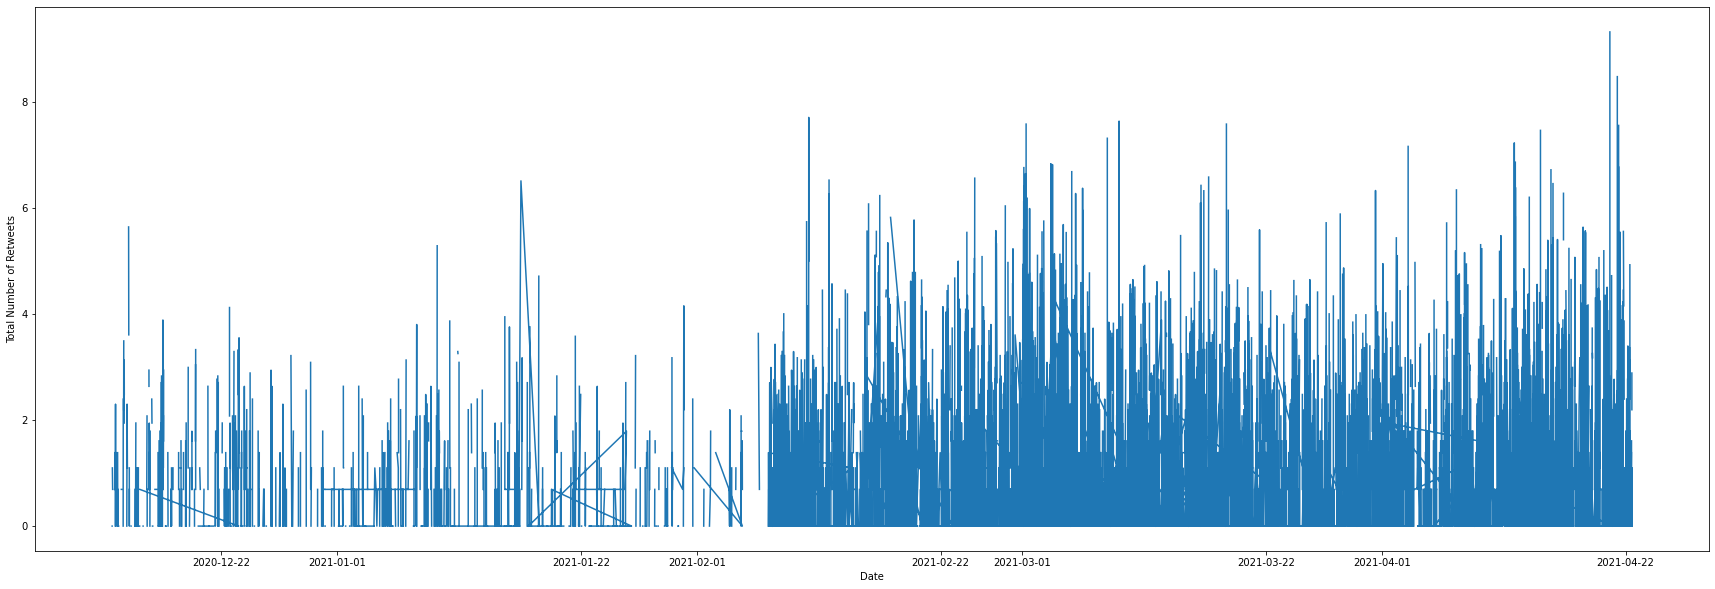

In [68]:
plt.figure(figsize=(30,10))
plt.plot(time_data['retweets'].apply(lambda x: np.log(x)))
plt.xlabel('Date')
plt.ylabel('Total Number of Retweets')
plt.show()

Here, we can see that the frequency of tweets at different times varies from day to day, but there is no clear indication of a seasonal or cyclical pattern. One thing to note however, is that as time goes on, the more dense the number of tweets gets in this data visualization. Now, we want to see how many retweets there were per tweet in the group over time. It would also be interesting to see how it compares of each week, which we can do below using a simple groupby function.

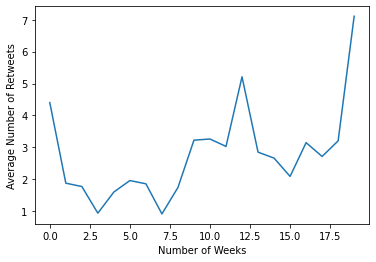

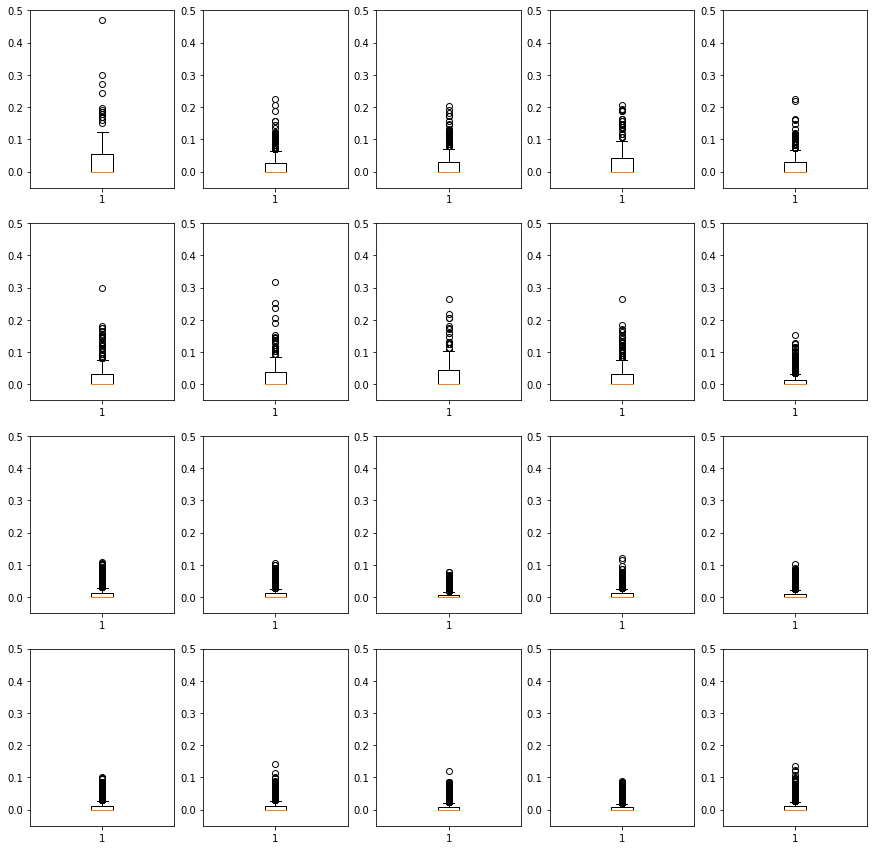

In [69]:
from sklearn.preprocessing import normalize
series = time_data['retweets']

groups = series.groupby(pd.Grouper(freq='W'))

avg_retweets = []
num_weeks = 0
all_groups = []
for name, group in groups:
  num_weeks += 1
  log_values = np.log(group.values + 1)
  log_values = np.reshape(log_values, (1, log_values.size))
  normalized = normalize(log_values)
  all_groups.append(normalized.flatten())
  avg_retweets.append(group.values.mean())

plt.plot(range(num_weeks), avg_retweets)
plt.xlabel('Number of Weeks')
plt.ylabel('Average Number of Retweets')
plt.show()

fig, axes = plt.subplots(4, 5, figsize=(15,15))

iter = 0
for i in range(4):
  for j in range(5):
    axes[i, j].boxplot(all_groups[iter])
    axes[i,j].set_ylim([-0.05, 0.5])
    iter += 1

We can see that the average retweets actually increases over time. Therefore, we can tell that there are more retweets as time goes on. However, there is not enough weekly data to exactly tell; there are outliers within the data set that make it a bit difficult to tell if the last week was just an outlier. Based on the boxplot, it appears that this may be the cause.

Based on our box plots, we can't really see much of a difference between them over time, suggesting that this data may be stationary. We can use the stationary test that was given in a Colab for module 23 in order to determine if this is a case. Note that if it passes ADF, meaning the p-value is low enough to reject the Null hypothesis, then the data is stationary.

Below, **we used the code from recitation colab for determining the ADF**.

In [70]:
from statsmodels.tsa.stattools import adfuller
from pandas import Series

def test_stationarity(timeseries, lags=None):
  rolmean = Series.rolling(timeseries, center=False, window=12).mean()
  rolstd = Series.rolling(timeseries, center=False, window=12).std()

  orig = plt.plot(timeseries, color='blue', label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

  print('Results of ADF Test:')
  if lags:
    dftest = adfuller(timeseries, autolag=None, maxlag=lags)
  else:
    dftest = adfuller(timeseries, autolag='AIC')

  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags', 'Observations'])
                     
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Here, we can tell that the data is stationary over all time. What we can next check is to see how that works for different time periods such as weeks and months. There are only a couple of months available to the data, so it would make more sense to do the rolling average tests on each week.

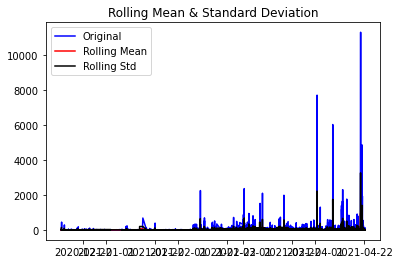

Results of ADF Test:
Test Statistic            -93.072710
p-value                     0.000000
#Lags                       7.000000
Observations            69710.000000
Critical Value (1%)        -3.430444
Critical Value (5%)        -2.861581
Critical Value (10%)       -2.566792
dtype: float64


In [71]:
test_stationarity(time_data['retweets'], 7)

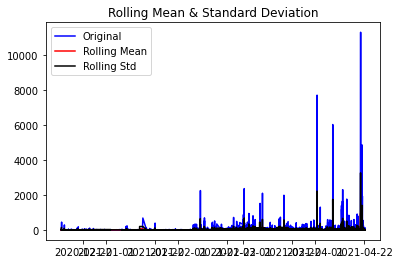

Results of ADF Test:
Test Statistic            -47.145340
p-value                     0.000000
#Lags                      30.000000
Observations            69687.000000
Critical Value (1%)        -3.430444
Critical Value (5%)        -2.861581
Critical Value (10%)       -2.566792
dtype: float64


In [72]:
test_stationarity(time_data['retweets'], 30)

This data is clearly stationary no matter how we put it. Therefore, there really isn't much to tell in terms of how COVID-19 tweets change in retweets and popularity over various time periods here. There are a number of outliers that make it seem a lot more different than it actually is in the data. Since we have that the data is stationary, it would not make sense to do an ARIMA model as those aim to capture non-stationary

# Challenges/Obstacles Faced Along the Way


Some of the obstacles that were faced along the way was geocoding the data. It was difficult at first to try to geocode the entire user location data, especially when some of the data was badly formatted. We tried to search for possible solutions, but most tweet analysis analysis we found also used the phrase data (e.g. "my bed") and considered it negligible. 

Another problem that we came across was creating a model for determining likes and finding a skewed data set. This was eventually resolved by using Random Forest as we did in lecture. We had thought that it would have originally made sense to use the Linear Regression, but even with PCA and other model adjustments, it was clear that the data could not be log-transformed into a normal distribution.

With the time-series data, there was ragged input data that made it hard to really compare the data across time. With some large outliers, it became heard to determine if there were truly any seasonal patterns or cycles going on until the ADF test, which helped us determine that ARIMA would not work here.



# Potential Next Steps


In the future, it may be interesting for EDA to zero in on analyzing tweets in specific locations in the world where high volumes of tweets are coming from, such as U.S. states or regions in India. It could also be interesting to see if we could categorize vaccine tweets by producer (e.g. Moderna, Pfizer) to see if there is a difference in sentiment with what people are tweeting.

For future modeling, it would be intersting to use  different models like SVMs to predict retweets to see if we can get a bitter fit.

Lastly, another idea we had would be to pull data about global vaccination progress to see whether a relationship exists between vaccine sentiment on Twitter and the
vaccination progress in the users’ respective countries.